## Import of Libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
import os

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm, tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from skimage import io
from PIL import Image
from IPython.display import clear_output
from pathlib import Path
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torchsummary

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

from matplotlib import colors, pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Simpsons Dataset

In [2]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']

# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

# работаем на видеокарте
DEVICE = torch.device("cuda")

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files) # список файлов для загрузки
        self.mode = mode # режим работы

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):

        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])

        augmentation = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.RandomRotation(25),
            transforms.RandomHorizontalFlip(),
            #transforms.RandomResizedCrop(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        x = torch.cat((x, augmentation(x)), 1)

        if self.mode == 'test':
            return x

        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [4]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)

    if title is not None:
        plt_ax.set_title(title)

    plt_ax.grid(False)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [6]:
!unzip -q /content/gdrive/My\ Drive/simpsons/journey-springfield.zip

In [7]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [8]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, stratify=train_val_labels)

In [9]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

In [10]:
trainloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

testloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False, 
    num_workers=2
)

## Functions for training

In [11]:
def train(model, optim, criterion, dataloader, epoch, device):
    total = 0
    correct = 0
    train_loss = 0
    
    model.train()

    for data, label in dataloader:
      
        data, label = data.to(device), label.to(device)
        optim.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optim.step()
        
        train_loss += loss.item()
        pred = output.argmax(1)
        total += output.shape[0]
        correct += pred.eq(label).sum().item()

    return train_loss / total, 100. * correct / total

In [12]:
def test(model, criterion, dataloader, epoch, device, best_acc, model_name='model'):
    total = 0
    correct = 0
    test_loss = 0
    
    model.eval()

    with torch.no_grad():

        for data, label in dataloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            
            loss = criterion(output, label)
            
            test_loss += loss
            pred = output.argmax(1)
            correct += torch.eq(pred, label).sum().item()
            total += data.shape[0]
    
    acc = 100.*correct/total

    if acc > best_acc:
        # print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }

        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')

        torch.save(state, './checkpoint/ckpt_{}.pth'.format(model_name))
    
    return test_loss / total, acc

In [13]:
torch.cuda.empty_cache()

## Model

In [14]:
#model = resnet18(pretrained=True)
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', pretrained=True)

torchsummary.summary(model.cuda(), (3, 32, 32))

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 

In [15]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(in_features=512, out_features=42)
sum([p.numel() for p in model.parameters() if p.requires_grad])

21546

In [16]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

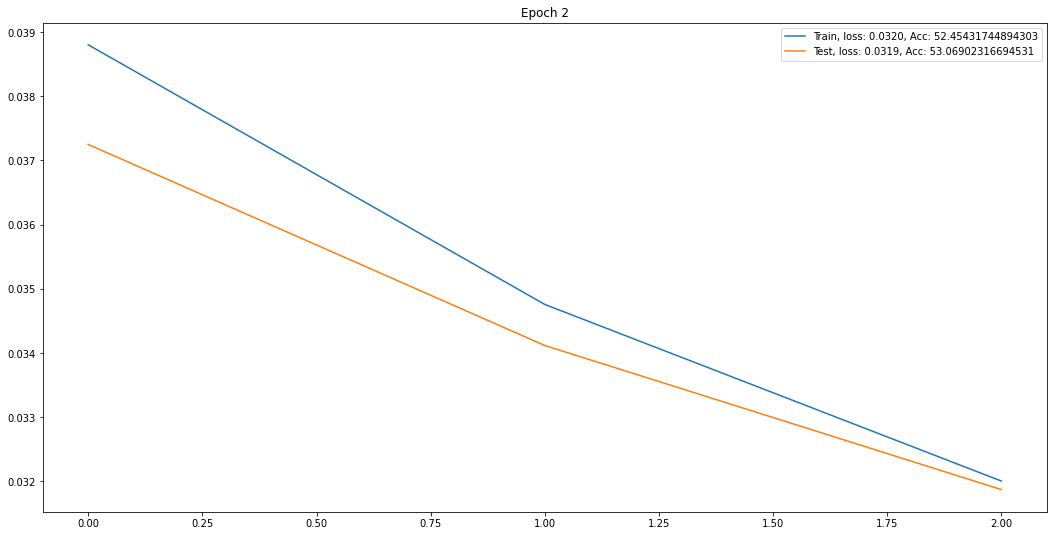

In [20]:
train_losses, test_losses = [], []
best_acc, best_epoch = 0, -1

def training(start, end, best_acc, best_epoch):
    for i in range(start, end):
        train_loss, train_acc = train(model, optimizer, criterion, trainloader, i, device)
        train_losses.append(train_loss)
        test_loss, test_acc = test(model, criterion, testloader, i, device, best_acc, 'resnet')
        scheduler.step(test_loss)
        test_losses.append(test_loss)

        best_acc = max(best_acc, test_acc)
        best_epoch = i if best_acc == test_acc else best_epoch

        clear_output()
        plt.figure(figsize=(18, 9))
        plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
        plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
        plt.title(f'Epoch {i}')
        plt.legend(loc='best')
        plt.show()

training(0, 3, best_acc, best_epoch)

In [21]:
for param in model.parameters():
    param.requires_grad = True

sum([p.numel() for p in model.parameters() if p.requires_grad])

21306218

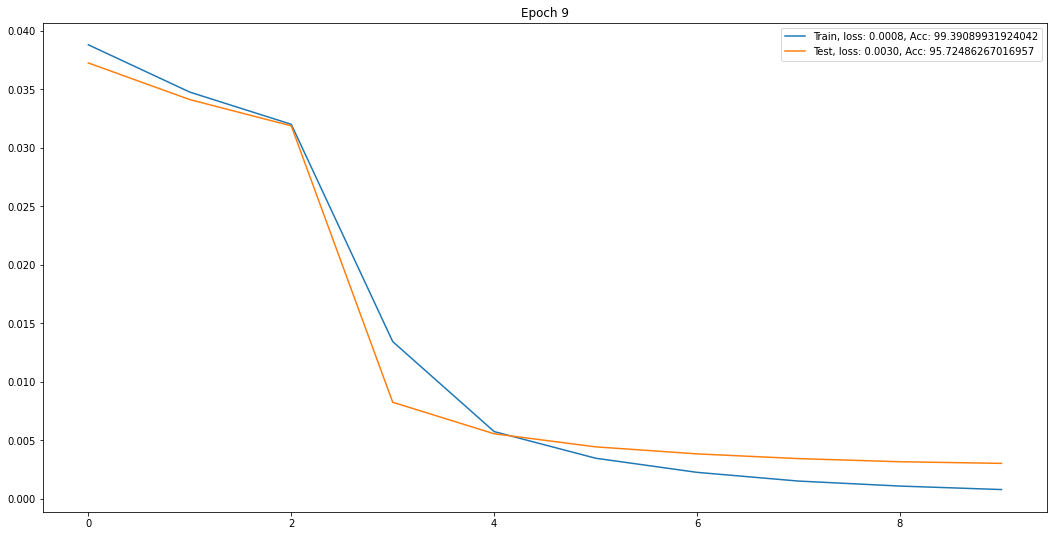

In [22]:
training(3, 10, best_acc, best_epoch)

## Predicting

In [24]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""

    with torch.no_grad():
      
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()

    return probs

In [25]:
random_characters = int(np.random.uniform(0, 1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [26]:
idxs = list(map(int, np.random.uniform(0, 1000, 900)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

In [28]:
def predict(model, test_loader):

    with torch.no_grad():

        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    
    return probs

In [29]:
probs_ims = predict(model, imgs)
probs_ims.shape

(900, 42)

In [30]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [31]:
y_pred = np.argmax(probs_ims, -1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [32]:
label_encoder.classes_[5]

'carl_carlson'

In [33]:
f1_score(actual_labels, y_pred, average='weighted')

0.9615718885465655

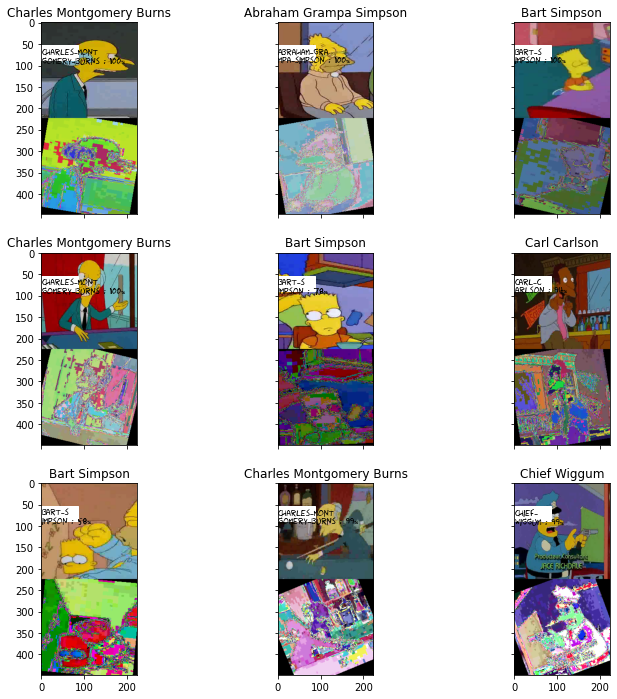

In [34]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), 
                       sharey=True, sharex=True)

for fig_x in ax.flatten():

    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred) * 100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label) // 2] + '\n' + predicted_label[len(predicted_label) // 2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
               verticalalignment='top', fontsize=8, color='black', fontweight='bold')

## Submit

In [36]:
def submit(files, batch_size, model, path):

    test_dataset = SimpsonsDataset(files, mode="test")
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
    probs = predict(model, test_loader)

    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    test_filenames = [path.name for path in test_dataset.files]

    my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
    my_submit.to_csv(path, index=False)


submit(test_files, 64, model, path='gdrive/My Drive/simpsons/my_submission.csv')